In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
from starccato_flow.plotting.plotting import plot_sky_localisation

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MPS device found


RA range: [-2.181, -1.309] rad
Dec range: [-1.402, -1.013] rad
Number of samples: 2000
Median position: RA=-1.747 rad, Dec=-1.206 rad
Median position: RA=-1.747 rad, Dec=-1.206 rad
Saved sky localization plot to plots/supernova_sky_localization.svg
Saved sky localization plot to plots/supernova_sky_localization.svg


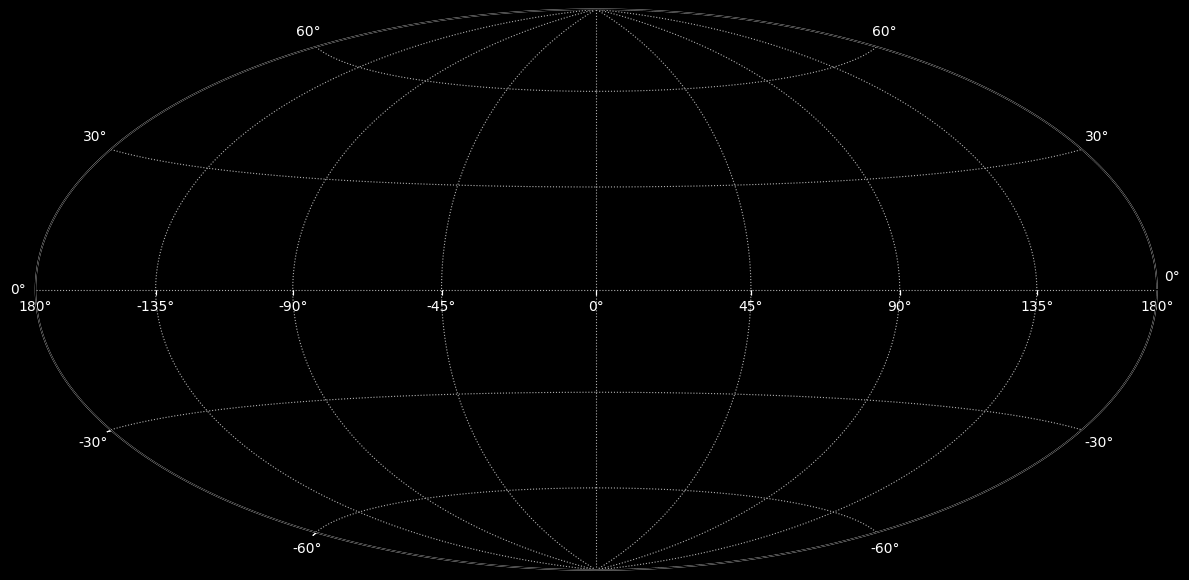

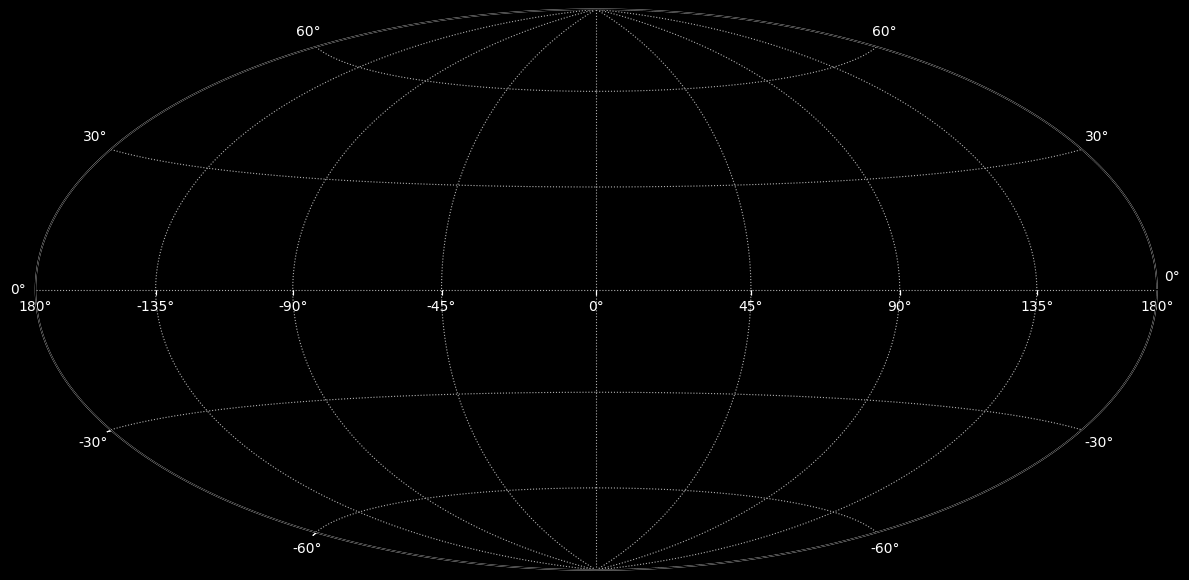

In [3]:
import numpy as np

# Simulate a detected supernova sky localization
# For a real LIGO detection, the localization is typically an arc/annulus on the sky
# due to time-of-arrival differences between detectors

# Let's put the supernova in the southern hemisphere
# Using realistic parameters for a multi-detector (LIGO H-L-V) detection

# True position: let's say near the Large Magellanic Cloud
# LMC is at approximately RA=80°, Dec=-69°
true_ra = np.deg2rad(80)  # Convert to radians
true_dec = np.deg2rad(-69)

# For LIGO detections, the uncertainty forms an arc/annulus
# The width is related to timing precision (~1-10 ms gives ~few degrees)
# The length is related to network geometry

# Create an elongated distribution (arc-like)
n_samples = 2000

# Generate samples along an arc
# Primarily elongated in RA direction
ra_sigma = np.deg2rad(25)  # ~25 degrees along the arc
dec_sigma = np.deg2rad(3)   # ~3 degrees perpendicular to arc

# Generate correlated samples to create arc shape
angle = np.random.uniform(-1, 1, n_samples)
ra_samples = true_ra - np.pi + angle * ra_sigma  # Offset for plotting
dec_samples = true_dec + np.random.normal(0, dec_sigma, n_samples)

# Add some curvature to make it more realistic
curvature = 0.05 * np.sin(angle * np.pi)
dec_samples += curvature

# Clip dec to valid range
dec_samples = np.clip(dec_samples, -np.pi/2, np.pi/2)

# Ensure RA is in valid range [-pi, pi]
ra_samples = np.arctan2(np.sin(ra_samples), np.cos(ra_samples))

plot_sky_localisation(
    ra_samples=ra_samples,
    dec_samples=dec_samples,
    background="black",
    fname="plots/supernova_sky_localization.svg"
)

Saved transparent streak overlay to plots/supernova_streak_overlay.png
Median position: RA=-100.00°, Dec=-66.18°
Confidence levels: 68%, 95%, 99.7% (crescent moon shape)


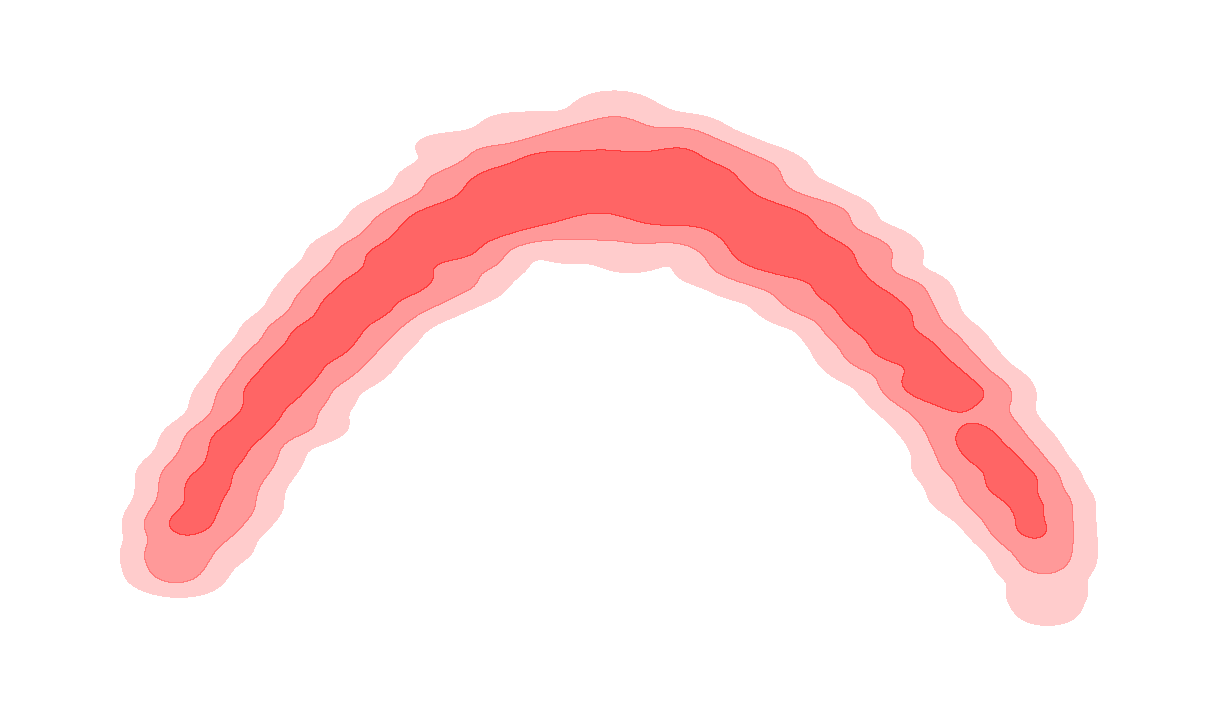

In [9]:
# Create a standalone density plot for the streak - star marker + confidence contours
# This can be overlaid on the sky map in image editing software

# Make a crescent moon shape (thin arc)
n_samples = 2000

# Create a crescent moon shape - arc with strong curvature
# Moon shape is like a parenthesis )
arc_angle = np.linspace(-0.8, 0.8, n_samples)  # Limited range for crescent

# Very thin crescent moon
ra_width = np.deg2rad(10)  # Width of the crescent
dec_width = np.deg2rad(0.8)  # Thickness of the crescent

# Create the crescent shape using parametric curve
ra_samples_thin = true_ra - np.pi + arc_angle * ra_width
# Quadratic curve for moon shape
dec_samples_thin = true_dec + 0.3 * (arc_angle ** 2) + np.random.normal(0, dec_width, n_samples)

# Clip to valid range
dec_samples_thin = np.clip(dec_samples_thin, -np.pi/2, np.pi/2)
ra_samples_thin = np.arctan2(np.sin(ra_samples_thin), np.cos(ra_samples_thin))

# Calculate KDE with bandwidth adjustment for thinner features
positions = np.vstack([ra_samples_thin, dec_samples_thin])
kde = gaussian_kde(positions, bw_method=0.08)  # Very sharp features

# Create a simple rectangular grid in RA-Dec space
ra_grid = np.linspace(ra_samples_thin.min() - 0.05, ra_samples_thin.max() + 0.05, 700)
dec_grid = np.linspace(dec_samples_thin.min() - 0.05, dec_samples_thin.max() + 0.05, 350)
ra_mesh, dec_mesh = np.meshgrid(ra_grid, dec_grid)

# Evaluate KDE on grid
density = kde(np.vstack([ra_mesh.ravel(), dec_mesh.ravel()])).reshape(ra_mesh.shape)

# Calculate credible region levels
sorted_density = np.sort(density.ravel())[::-1]
cumsum = np.cumsum(sorted_density)
cumsum /= cumsum[-1]

level_997 = sorted_density[np.argmax(cumsum >= 0.997)]
level_95 = sorted_density[np.argmax(cumsum >= 0.95)]
level_68 = sorted_density[np.argmax(cumsum >= 0.68)]

# Calculate median position (not mean)
ra_median = np.median(ra_samples_thin)
dec_median = np.median(dec_samples_thin)

# Create figure with no axes
fig, ax = plt.subplots(figsize=(12, 7), facecolor='none')
ax.set_position([0, 0, 1, 1])  # Fill entire figure
ax.axis('off')

# Set the limits to match our grid
ax.set_xlim(ra_grid[0], ra_grid[-1])
ax.set_ylim(dec_grid[0], dec_grid[-1])

# Plot shaded contours (filled) for different confidence levels
contour_levels = [level_997, level_95, level_68, density.max()]
contours = ax.contourf(ra_mesh, dec_mesh, density,
                       levels=contour_levels,
                       colors=['#FF0000', '#FF0000', '#FF0000'],
                       alpha=[0.2, 0.4, 0.6],
                       extend='neither')

# Plot star marker at the median position - much bigger
# ax.plot(ra_median, dec_median, 
#         marker='*', 
#         markersize=50,
#         color='#FF0000',
#         markeredgecolor='white',
#         markeredgewidth=2,
#         zorder=10)

# Invert y-axis to match typical astronomical convention
ax.invert_yaxis()

plt.savefig("plots/supernova_streak_overlay.png", 
            dpi=300, 
            transparent=True, 
            bbox_inches='tight',
            pad_inches=0)
print("Saved transparent streak overlay to plots/supernova_streak_overlay.png")
print(f"Median position: RA={np.rad2deg(ra_median):.2f}°, Dec={np.rad2deg(dec_median):.2f}°")
print(f"Confidence levels: 68%, 95%, 99.7% (crescent moon shape)")
plt.show()